# Shopper similarity analysis

This notebook tries to find if there are similarities in shopper behaviour using network analysis.

## Theory

**Girvan Newman**

The Girvan–Newman algorithm detects communities by progressively removing edges from the original graph. The algorithm removes the “most valuable” edge, traditionally the edge with the highest betweenness centrality, at each step. As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram.

**Edge betweenness centrality**

Compute betweenness centrality for edges.

Betweenness centrality of an edge e is the sum of the fraction of all-pairs shortest paths that pass through e:

$$ c_b(e) = \sum_{s, t \ \in V} \frac{\sigma(s, t \mid e)}{\sigma(s, t)} $$


## Load dependencies

In [1]:
import pandas as pd
import numpy as np
import copy

from scipy import stats

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from msci.utils import utils
from msci.analysis.networks import *
from msci.utils.plot import create_count_of_shoppers_gif, create_count_of_shoppers_image
from msci.utils.plot import plot_path_jn

In [4]:
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman

## Import raw data

In [430]:
signal_df = utils.import_signals('Mall of Mauritius', version=3, signal_type=1)

In [431]:
from msci.cleaning.store_ids import clean_store_id

In [432]:
cleaner_signal_df = clean_store_id(signal_df[signal_df.store_id.notnull()])

HBox(children=(IntProgress(value=0, max=266), HTML(value='')))

In [435]:
analysis_mac_addresses = cleaner_signal_df.mac_address.drop_duplicates().tolist()[5000:5050]

## Method

We want to create a matrix which will enable us to determine how similar two shoppers are. We can then perform various measures on this dataset such as:
- community detection
- xxx

Create a shopper normalised similarity matrix:
- get the signals from the mall
- create a pivot data which contains shopper on the x-axis and shops on the y-axis and the signal count as the value
- turn all signal counts to 1
- for every pair of shoppers $Aij$ calculate the number of stores that they both went to
- divide each connection by the total number of shops visited for the $i$th shopper

This has now created a weighted directional network $A$ which gives the shopper $i$'s similarity to shopper $j$. The similarity is calculated by the number of shops they both went to divide by the number of shops shopper $i$ went to.

## Get data

In [413]:
def create_shopper_shop_pivot(signal_df, mac_address=None):
    clean_signal_df = signal_df[
        signal_df.store_id.notnull() & 
        signal_df.store_id.str.contains('B')
    ]
    if mac_address is not None:
        clean_signal_df = clean_signal_df[clean_signal_df.mac_address.isin(mac_address)]
    shopper_shop_pivot = pd.pivot_table(clean_signal_df, values='x', index='mac_address', columns='store_id', aggfunc=len)
    return shopper_shop_pivot

In [414]:
def create_similarity_matrix(shopper_shop_df, num_entities=100, skip_entities=0):
    """
    Creates a shop or shopper similarity matrix. 
    The x-axis is entities which the similarity is based on and y-axis is overlap which is being counted.
    E.g. a shopper shopper matrix will contain the number shops both shopper_i and shopper_j both went to
    E.g. a shop shop matrix will contain the number of shoppers that both went to shop_i and shop_j
    
    :param shopper_shop_df: (pd.DataFrame) the shoppers on one axis with the shops on the other
    :return: (pd.DataFrame) entity entity matrix with the number of overlap in the value (entity is shop or shopper)
    """
    shopper_shop_df[shopper_shop_df > 0] = 1
    # shopper_shop_df = shopper_shop_df[shopper_shop_df.notnull().sum(axis=1) == 5]
    shopper_shop_index_df = (shopper_shop_df * np.arange(shopper_shop_df.shape[1]))[skip_entities:skip_entities+num_entities]
    similarity_df = pd.DataFrame(0, shopper_shop_index_df.index, shopper_shop_index_df.index)
    
    for i in range(len(similarity_df.index)):
        entity_index_i = shopper_shop_index_df.iloc[i][shopper_shop_index_df.iloc[i].notnull()]
        for j in range(i+1, (len(similarity_df.index))):
            entity_index_j = shopper_shop_index_df.iloc[j][shopper_shop_index_df.iloc[j].notnull()]
            num_overlap = len(list(set(entity_index_i) & set(entity_index_j)))
            similarity_df.iloc[i, j] = num_overlap
            
    norm = shopper_shop_index_df.notnull().sum(axis=1)
            
    return similarity_df / norm + similarity_df.T / norm

In [439]:
shopper_shop_pivot = create_shopper_shop_pivot(signal_df, analysis_mac_addresses)
shopper_similarity_df = create_similarity_matrix(shopper_shop_pivot, num_entities=51, skip_entities=0)

## Create network

In [441]:
G = nx.from_numpy_matrix(shopper_similarity_df.as_matrix(), create_using=nx.MultiDiGraph())
G = nx.relabel_nodes(G, dict(enumerate(shopper_similarity_df.columns)))

In [442]:
comp = girvan_newman(G)
communities = tuple(sorted(c) for c in next(comp))

In [443]:
communities

(['1c:7b:21:31:63:5e',
  '28:27:bf:4e:24:51',
  '2c:59:8a:22:f1:4b',
  '2c:ae:2b:b3:3b:b3',
  '34:aa:8b:7d:92:26',
  '38:2d:e8:bf:24:9e',
  '38:aa:3c:37:50:c1',
  '40:f3:08:28:80:65',
  '40:f3:08:7c:24:b0',
  '4c:66:41:04:8d:45',
  '50:2e:5c:58:e6:8d',
  '50:fc:9f:7b:db:87',
  '60:f4:45:cd:fe:2d',
  '64:bc:0c:92:d7:70',
  '6c:2f:2c:38:99:0d',
  '78:4b:87:87:99:b8',
  '78:c3:e9:37:9b:34',
  '78:c3:e9:ba:41:c6',
  '78:c3:e9:ba:b1:ae',
  '78:c3:e9:d9:c7:f6',
  '7c:91:22:35:58:dc',
  '7c:c5:37:16:29:d3',
  '80:ea:96:6a:e3:20',
  '84:21:41:1a:78:e8',
  '84:2e:27:50:47:e4',
  '8c:bf:a6:7c:4c:4b',
  '9c:5c:f9:69:e1:ba',
  'a0:cb:fd:c9:c0:7c',
  'ac:0d:1b:a7:1f:ca',
  'ac:5f:3e:58:a4:c0',
  'ac:5f:3e:e2:7f:99',
  'ac:7f:3e:68:87:f8',
  'b0:e2:35:fc:a0:d4',
  'b4:74:43:d4:2b:dd',
  'c8:1e:e7:a0:52:91',
  'd0:13:fd:4d:1a:3b',
  'd0:22:be:94:9f:ea',
  'd8:5b:2a:8e:af:27',
  'dc:78:34:61:7c:6b',
  'e8:50:8b:78:62:eb',
  'e8:50:8b:a7:fa:9b',
  'ec:1f:72:b0:60:13',
  'ec:9b:f3:20:a9:8e',
  'ec:9b:f3

In [444]:
shopper_similarity_matrix = shopper_similarity_df.as_matrix()
shopper_similarity_matrix_binary = copy.deepcopy(shopper_similarity_matrix)
shopper_similarity_matrix_binary[np.where(shopper_similarity_matrix_binary > 0)] = 1
shopper_similarity_matrix_binary

array([[ 0.,  1.,  1., ...,  1.,  0.,  1.],
       [ 1.,  0.,  1., ...,  0.,  0.,  1.],
       [ 1.,  1.,  0., ...,  1.,  0.,  1.],
       ..., 
       [ 1.,  0.,  1., ...,  0.,  1.,  1.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 1.,  1.,  1., ...,  1.,  0.,  0.]])

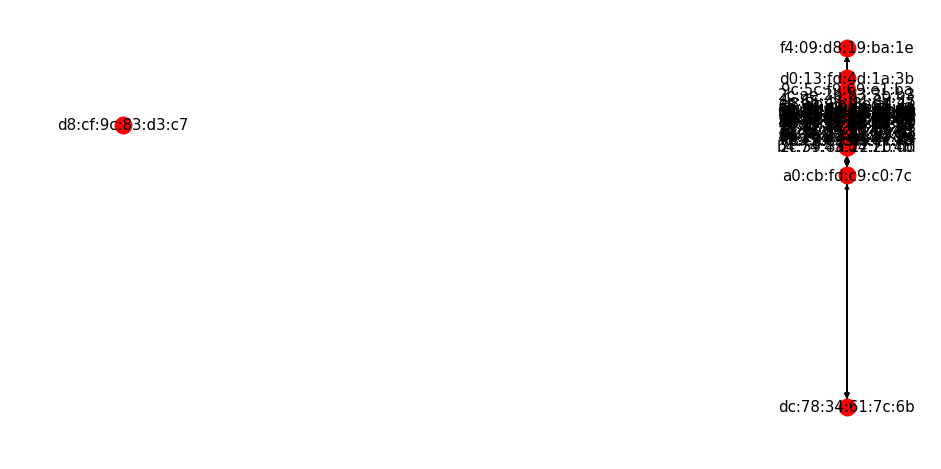

In [445]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
pos = nx.spectral_layout(G)
nx.draw_spectral(G)
labels = {i : i for i in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=15)
plt.savefig('destination_path.png', format='png', dpi=1000)
plt.show()

In [446]:
G.edges(data=True)

OutMultiEdgeDataView([('1c:7b:21:31:63:5e', '28:27:bf:4e:24:51', {'weight': 1.0}), ('1c:7b:21:31:63:5e', '2c:59:8a:22:f1:4b', {'weight': 0.5555555555555556}), ('1c:7b:21:31:63:5e', '34:aa:8b:7d:92:26', {'weight': 0.3}), ('1c:7b:21:31:63:5e', '38:2d:e8:bf:24:9e', {'weight': 0.5625}), ('1c:7b:21:31:63:5e', '38:aa:3c:37:50:c1', {'weight': 0.3333333333333333}), ('1c:7b:21:31:63:5e', '40:f3:08:28:80:65', {'weight': 0.6}), ('1c:7b:21:31:63:5e', '40:f3:08:7c:24:b0', {'weight': 0.5}), ('1c:7b:21:31:63:5e', '4c:66:41:04:8d:45', {'weight': 0.6}), ('1c:7b:21:31:63:5e', '50:2e:5c:58:e6:8d', {'weight': 0.2222222222222222}), ('1c:7b:21:31:63:5e', '50:fc:9f:7b:db:87', {'weight': 0.42857142857142855}), ('1c:7b:21:31:63:5e', '60:f4:45:cd:fe:2d', {'weight': 0.3157894736842105}), ('1c:7b:21:31:63:5e', '64:bc:0c:92:d7:70', {'weight': 0.5333333333333333}), ('1c:7b:21:31:63:5e', '6c:2f:2c:38:99:0d', {'weight': 0.5714285714285714}), ('1c:7b:21:31:63:5e', '78:4b:87:87:99:b8', {'weight': 0.5263157894736842}), 

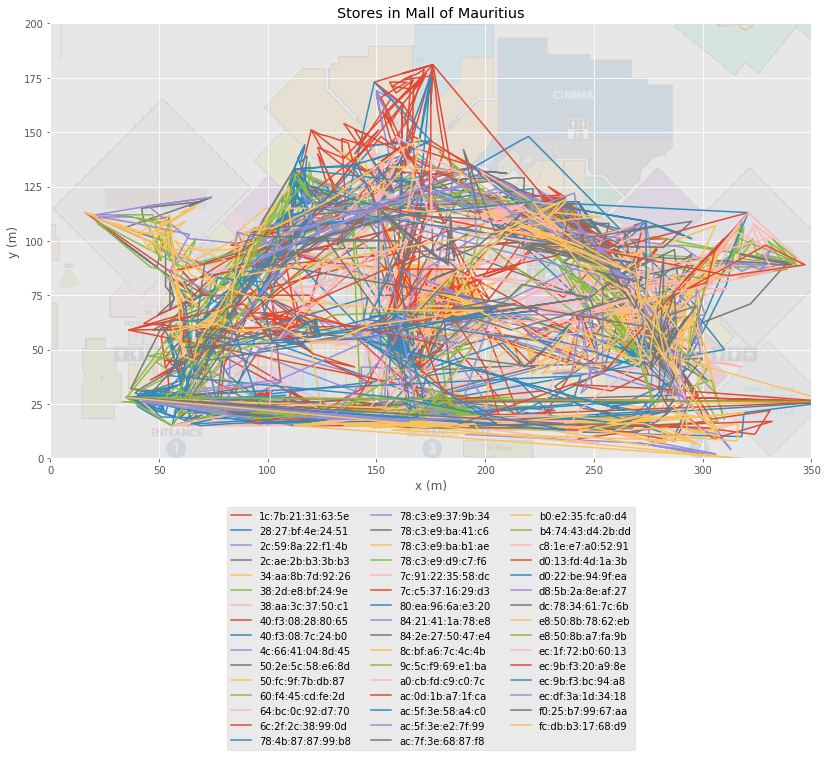

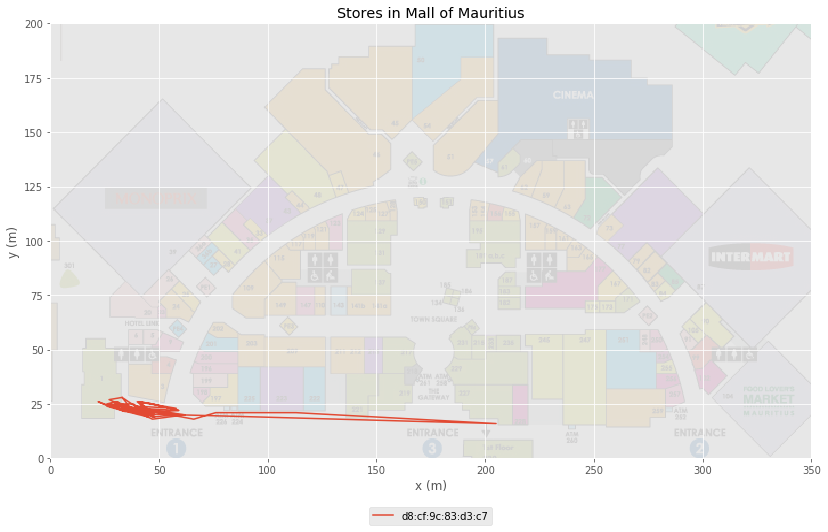

In [447]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
plot_path_jn(signal_df, communities[0], axes=ax, scatter=False)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
plot_path_jn(signal_df, communities[1], axes=ax, scatter=False)

In [289]:
for shopper in communities[1]:
    print(signal_df[(signal_df.mac_address == shopper) & signal_df.store_id.str.contains('B')].store_id.unique())

['B197' 'B225' 'B109' 'B46' 'B3' 'B119' 'B177' 'B104']
['B3' 'B125' 'B250' 'B141A' 'B131' 'B137']
['B9' 'B177']
['B46' 'B33' 'B41' 'B228' 'B217' 'B213']
['B46' 'B57' 'B231' 'B250' 'B119' 'B117' 'B33' 'B36B' 'B28' 'B149' 'B197']


Two sets of paths on two maps of Mall of Mauritius. The each set of paths shows a different community detected by the Girvan–Newman algorithm. Each paths is connected to the next via the number of stories they both went to divide by the number of stores that path went to.

## Investigate deeper

In [41]:
import itertools

In [448]:
G = nx.from_numpy_matrix(shopper_similarity_df.as_matrix(), create_using=nx.MultiDiGraph())
# G = nx.relabel_nodes(G, dict(enumerate(shopper_similarity_df.columns)))

In [449]:
k = 50
comp = girvan_newman(G)
for communities in itertools.islice(comp, k):
    print(tuple(sorted(c) for c in communities)) 

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 48], [38], [47])
([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 48], [38], [39], [47])
([0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 48], [8], [38], [39], [47])
([0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 48], [8], [9], [38], [39], [47])
([0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 48], [8], [9], [26], [38], [39], [47])
([0, 1, 2, 3, 4

([0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15, 20, 21, 22, 24, 25, 28, 29, 32, 36, 46, 48], [16], [17], [18], [19], [23], [26], [27], [30], [31], [33], [34], [35], [37], [38], [39], [40], [41], [42], [43], [44], [45], [47])
([0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20, 21, 22, 24, 25, 28, 29, 32, 36, 46, 48], [23], [26], [27], [30], [31], [33], [34], [35], [37], [38], [39], [40], [41], [42], [43], [44], [45], [47])
([0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21, 22, 24, 25, 28, 29, 32, 36, 46, 48], [23], [26], [27], [30], [31], [33], [34], [35], [37], [38], [39], [40], [41], [42], [43], [44], [45], [47])
([0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22, 24, 25, 28, 29, 32, 36, 46, 48], [23], [26], [27], [30], [31], [33], [34], [3

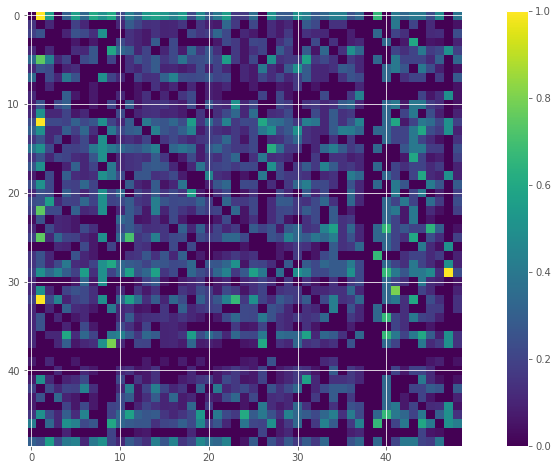

In [451]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
plt.imshow(shopper_similarity_df.as_matrix())
plt.colorbar()